# AB Test Case Study

### Introduction

To consolidate what we've learned in the previous class around hypothesis testing, let's dip our toes with a practical example involving an AB Test in an online business context. 

#### Background

A recent **competitive benckmark analysis** has shown that there is margin to improve the conversion rate of the checkout funnel, so *the product and design teams* have been working together in the past weeks to come up with a restyling of the **cart page** that, hopefully, will increase conversions. 

The new version includes many changes to the current page and, being the business particularly data-driven, they want to **change one major component at the time** in order to be able to quantify any differences. 

#### Your Goal

You've been asked to **design and implement an experiment** to test if, after implementing the first feature, there is any **difference in conversion rate** between the old and the new cart page. 

### Design of the experiment

#### Preliminary Steps

1. First of all, you need to find the **baseline conversion rate** that is, the average conversion rate of the current cart page, so you head over to Google Analytics and find that it's around 11.5%. 

2. Talking with *your stakeholders*, you all agree that you would expect to see at least a 1% increase (in absolute terms) with the new cart page, so you insert this information in an [online calculator](https://www.evanmiller.org/ab-testing/sample-size.html) in order to find the **minimum sample size** required: 

In [3]:
from IPython.display import IFrame
IFrame(src="https://www.evanmiller.org/ab-testing/sample-size.html#!11.5;80;5;1;0", width='100%', height='400px')

3. With a baseline conversion rate of 11.5% and a minimum detectable effect of 1% (in absolute terms), you need a **minimum sample size** of at least 16,154 observations per group (control and treatment). 

4. Since your company's business cycle, from first contact to conversion, takes about 10 days on average, you decide to **run the experiment for at least three full weeks**. 

#### Implementation

At this point, you reach the *software development team* that looks after the core codebase of the e-commerce platform and explain the challenge: you need them to implement a solution that allows you to **divert 50% of the traffic** to the old cart page and the remaining 50% of the traffic to its newly restyled version. 

A key aspect of this solution is that the traffic must be divided into **two groups of equal size**, and **subjects must be assigned randomly** to each one of the two groups. 

The **results** will be easily accessible in a **tabular format** with the following carachteristics: 

- each observation will be identifyied by a user id and a date value
- each user will be flagged as part of the 'control' or 'treatment' group
- for each user, it will be recorded the actual cart page name that was displayed, between 'old_cart' and 'new_cart'
- a user who converted will be flagged with a 1 

### Data Analysis

A little more than three weeks later, you retrieve your results and load them in a Python DataFrame named `df`:

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels 

/Users/franz/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
df_raw = pd.read_csv('data/ab-test-case-study.csv')

In [6]:
df_raw.head()

,uid,date,group,page,converted
0,851104,2017-01-21,treatment,new_cart,0
1,804228,2017-01-12,treatment,new_cart,0
2,661590,2017-01-11,control,old_cart,0
3,853541,2017-01-08,control,old_cart,0
4,864975,2017-01-21,treatment,new_cart,1


As a first thing, you do an **initial check on the data**, make sure there are no missing values and convert the `date` variable to a date object:

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        294478 non-null  int64 
 1   date       294478 non-null  object
 2   group      294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df = df_raw.copy()
df['date'] = pd.to_datetime(df['date']).dt.date

As a first check on the **consistency of the data**, you check that the `group` and `page` variables have a one-to-one relationship ('control' -> 'old_cart' and 'treatment' -> 'new_cart'). To do this, you create a summary table where you aggregate those two variables and count how many observations there are for each possible combination of their categories:

In [9]:
df.groupby(['group', 'page'], as_index=False).size()

,group,page,size
0,control,new_cart,1965
1,control,old_cart,145311
2,treatment,new_cart,145274
3,treatment,old_cart,1928


You notice that some users were assigned a 'control' label but actually saw the 'new_cart' and, vice versa, others were assigned a 'treatment' label but actually saw the 'old_cart'. This was likely caused by a **bug or an exception** in the traffic split system; luckily there aren't many of these instances, so you filter out the inconsistencies. 

In [10]:
df = df[(df.group=='control')&(df.page=='old_cart') | (df.group=='treatment')&(df.page=='new_cart')]

In [11]:
df.groupby(['group', 'page'], as_index=False).size()

,group,page,size
0,control,old_cart,145311
1,treatment,new_cart,145274


According to your experimental design, a user id should appear only once in the dataset: if multiple sessions were recorded, then only the last session should be tracked, and a value of either 1 or 0 should be assigned to the `converted` variable accordingly. So, as a second check, you make sure that there are no duplicated values in the `uid` column: 

In [12]:
df.uid.value_counts()

773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: uid, Length: 290584, dtype: int64

In [13]:
df[df['uid']==773192]

,uid,date,group,page,converted
1899,773192,2017-01-09,control,old_cart,0
2893,773192,2017-01-14,control,old_cart,0


You notice that there is one user id '773192' that appears twice in two different dates and has never converted. In order to **avoid having duplicates** in the data, you decide to keep only the most recent record: 

In [14]:
df = df.drop(df[(df.uid == 773192) & (df.date == pd.to_datetime('2017-01-09').date())].index)

In [15]:
df[df['uid']==773192]

,uid,date,group,page,converted
2893,773192,2017-01-14,control,old_cart,0


As a final step, in order to get a first impression of the results, you **plot a time series** of the daily avereage conversion rate as well as a **summary table containing some useful statistics** for both the control and treatment groups. 

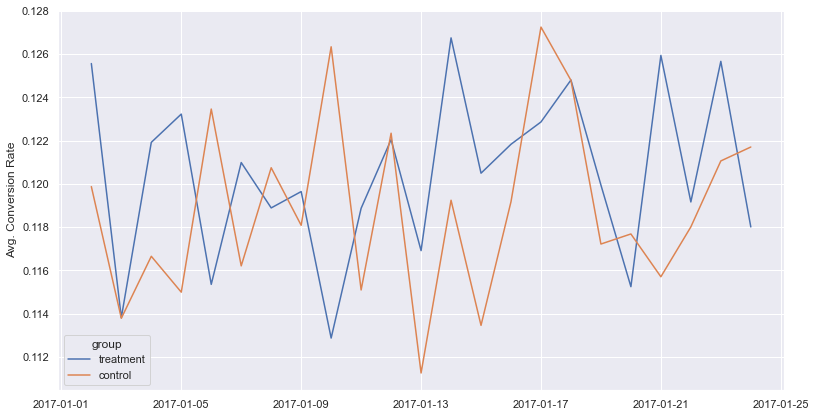

In [16]:
fig, ax = plt.subplots(figsize=(13, 7))
p = sns.lineplot(x='date', y='converted', hue='group', data=df, ci=None)
p.set_xlabel('')
p.set_ylabel('Avg. Conversion Rate')
plt.show()

In [17]:
df.groupby('group', as_index=False).agg({'converted': ['count', 'sum', np.mean]})

group converted                 
                 count    sum      mean
0    control    145310  17264  0.118808
1  treatment    145274  17489  0.120386

From the summary table we can immediately see that the two groups have a similar sample size, which means that the 50% traffic split process worked as expected. It is also visible that **the treatment group registered a higher number of conversions** compared to the control group. The rest of the analysis will be devoted to **finding out whether this difference is statistically significant** and can thus be attributed to the restyling of the cart page. 

### Hypothesis Testing

You decided that you'll be using a **permutation test** in order to assess whether the different conversion rate that was recorded for the two groups (control and treatment) is statistically significant. 

Let's **briefly recap** what a permutation test is and how it is conducted in practice.

Classical parametric statistical tests require the analyst to make assumptions on the data distribution as well as understanding mathematical formulas. This gives the false impression that experimental design is plain and hard to understand. 

Permutation tests are **non-parametric**, they have very **little assumptions** on the data distribution, they can be applyied in most experimental scenarios, especially in **business AB testing** contexts and, being **light on formulas**, are quite intuitive to understand. 

#### The Null Hypothesis

*Note: this process is implicitely conducted in the preliminary steps of the design of the experiment*

Just like in traditional statistical testing, we need to frame our experiment in terms of a **set of hypothesis**; in our case, we believe that the visitors exposed to the 'new_cart' page (treatment group) will have a higher conversion rate than those exposed to the 'old_cart' page (control group). 

In hypothesis testing, we then proceed with a *[reductio ad absurdum](https://en.wikipedia.org/wiki/Reductio_ad_absurdum)* (RAA) reasoning: 

> a hypothesis is shown to be valid by demonstrating the improbability of the consequence that results from assuming the counter-claim to be true

In our case, the **counter-claim** would be that there is **no difference** between the old and new cart pages and thus we expect to see no difference in conversion rate ($CR$) between the control and treatment groups. We call this counter-claim the **null hypothesis** ($H_0$), which we *assume to be true* per the RAA reasoning, as opposed to the **alternative hypothesis** ($H_1$), which is the hypothesis we hope to *demonstrate to be true*. 

$$
    \begin{gather}
        H_0: CR_{treatment} \leq CR_{control} \\
        H_1: CR_{treatment} > CR_{control}
    \end{gather}
$$

#### The Test Statisitc

To determine whether or not the new cart page really is more effective at driving conversions, we need a way to quantify the difference between our null and alternative hypotheses; to do this, we use a **test statistic**.

We will use the difference in conversion rate between the two groups:

$$
    \text{Test Statistic} = CR_{treatment} - CR_{control}
$$

To obtain our initial **observed test statistic**, we subtract the conversion rate of the control group from that of the treatment group:

In [18]:
mu_control = np.mean(df[df.group=='control']['converted'])
mu_treatment = np.mean(df[df.group=='treatment']['converted'])
mu_diff = mu_treatment - mu_control
print('Observed test statistic:', mu_diff)

Observed test statistic: 0.0015782389853555567


#### The Permutation Process

*Note: to permute means to shuffle, rearrange, swap, ...*

Remember that, because of our RAA reasoning, we're assuming that there is no difference in conversion rate between the two groups. That means that, **under the null hypothesis**, if we were to: 

1. take all of our observations
2. remove the 'treatment' and 'control' labels
3. shuffle them *(irrespective of their group labels)* 
4. divide them into two random groups
5. calculate the conversion rate of the two groups

<img src="img/permute.png" width="700">

then we should obtain a similar conversion rate for both groups. That is, the difference in conversion rate between "group 1" and "group 2" in the picture above, let's call it **simulated test statistic**, should be close to zero. 

If we **repeat this process many times**, say 500 times (but it could be more depending on the size of your data and computing power), and each time we record the value of the simulated test statistic, we could then generate a histogram with these 500 values and thus visualise the **distribution of the test statistic under the null hypothesis** that there is no difference between the two groups. 

In [19]:
n = 500
mu_diff_samples = []
for i in range(n): 
    # extract a subsample of 50% of data without replacement
    df_sample1 = df.sample(frac=0.5, replace=False)
    # use set() to get indexes of rows that were not extracted from df in previous step
    ix2 = set(df.index) - set(df_sample1.index)
    # create dataframe with other 50% of data
    df_sample2 = df.loc[list(ix2)]
    # calculate difference in mean from each sample
    mu_diff_temp = np.mean(df_sample1['converted']) - np.mean(df_sample2['converted'])
    # append sampled mean difference to mu_diff_samples list
    mu_diff_samples.append(mu_diff_temp)

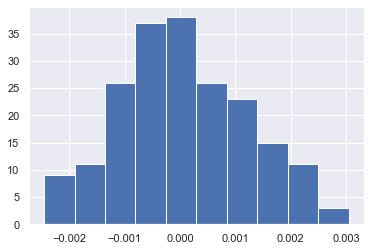

In [20]:
import matplotlib.animation as animation

number_of_frames = 200

def update_hist(num, data):
    plt.cla()
    plt.hist(data[:num])

fig = plt.figure()
hist = plt.hist(mu_diff_samples[0])

animation = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(mu_diff_samples, ) )

from IPython.display import HTML
HTML(animation.to_jshtml())

In [22]:
!brew install imagemagick

Running `brew update --preinstall`...
==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
adamstark-audiofile                      maclaunch
agg                                      manifest-tool
astro                                    mariadb@10.7
aws-nuke                                 markdown-toc
aws2-wrap                                mcap
aztfy                                    meek
berkeley-db@5                            mesheryctl
bfgminer                                 metalang99
burst                                    mkp224o
c2rust                                   mle
cargo-bundle                             mprocs
cargo-crev                               mypaint-brushes
cargo-depgraph                           nali
cargo-nextest                            nb
cargo-udeps                              neovide
censys          

In [ ]:
animation.save('/Users/franz/animation.gif', writer='imagemagick', fps=60)

MovieWriter imagemagick unavailable; using Pillow instead.


#### The p-value

Now, let's see where does the <span style="color:Crimson">**observed test statistic**</span> (red dashed line) lay with respect to the distribution of the <span style="color:SteelBlue">**simulated test statistic under the null hypothesis**</span> (blue histogram). 

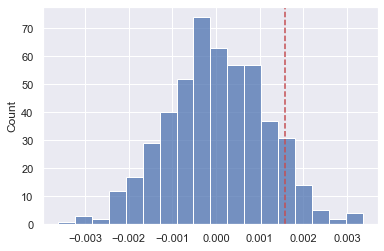

Avgerage Simulated Test Statistic: 0.0000
Initially Observed Test Statistic: 0.0016


In [19]:
sns.histplot(mu_diff_samples)
plt.axvline(mu_diff, 0, 1, color='r', linestyle='--')
plt.show()
print('Avgerage Simulated Test Statistic:', f'{np.mean(mu_diff_samples):.4f}')
print('Initially Observed Test Statistic:', f'{mu_diff:.4f}')

As we expected, the distribution of the simulated test statistic under the null hypothesis is centered on a mean of zero, now the question we need to ask ourselves is the following: 

> how likely is it to observe a value like the one of the observed test statistic, assuming there is no difference between the groups?

Or, in more technical terms: 

> what is the probability of obtaining simulated results **at least as extreme as** the result actually observed, under the assumption that the null hypothesis is correct?

This probability we're talking about is the **p-value** and we can easily calculate it by simply counting the number of simulated results that are greater than or equal to our observed test statistic and dividing this number by the total number of simulated results (500 in our example). 

In [20]:
print('Results more extreme than observed:', sum([el >= mu_diff for el in mu_diff_samples]))
print('Total results:', len(mu_diff_samples))
p_value = sum([el > mu_diff for el in mu_diff_samples])/n
print('p-value:', sum([el >= mu_diff for el in mu_diff_samples]), '/', len(mu_diff_samples), '=', p_value)

Results more extreme than observed: 41
Total results: 500
p-value: 41 / 500 = 0.082


This probability could be interpreted as follows: 

> **assuming there is no difference** between the two groups (ie: null hypothesis is true) **you have a 8.8% chance of observing** a difference in conversion rate (ie: your observed test statistic) **of 0.0016, or higher**. 

Is 8.8% high or low? The answer is subjective and it depends, mainly on the subject that's been studied: 

- if you're developing a new drug and are testing if it can be harmful to humans, you'll want that probability to be as low as possible (way below 1%); 
- if you're developing a new checkout cart page and are testing if it will deliver more conversions, you can take a more relaxed stance and accept a higher level of uncertainty (say 5% or 10%). 

#### The Significance Level



Statisticians don't like the idea of leaving to the researcher or analyst the decision of determining whether a result is “too unusual” to happen by chance, therefore a threshold, known as **alpha** or as the **significance level**, is specified **in advance**. 

This means that, **before running the hypothesis test**, you should **specify an alpha level** such that, if the p-value is greated than the threshold you've selected, you will accept the null hypothesis that there is no significant difference between the two groups. 

**Commonly used alpha levels** are 10%, 5% and 1%. The lower the alpha level, the more stringent the test.

Let's pretend that, since you're not too worried about making a [type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors), you selected an alpha level of 10%. 

### Conclusions



The final step is thus to **compare the p-value with the significance level** and, based on the outcome, make the final conclusions. 

In [21]:
alpha = 0.1

if p_value <= alpha: 
    print('H0 rejected: the observed result is statistically significant | p-value <= alpha')
else: 
    print('H0 accepted | the observed result is not statistically significant | p-value > alpha')

H0 rejected: the observed result is statistically significant | p-value <= alpha


Given the fact that $\alpha=10%$ and $\text{p-value}=8.8\%$, we can state that the p-value is less than the chosen alpha level; in fact, at our 10% level of significance, **we reject the null hypothesis** and accept the alternative: 

> there seems to be a **significant difference** between the conversion rate of the treatment and control groups.

*As a final consideration, notice the fact that, had we chosen a lower significance level, say $\alpha = 5%$, we would have accepted the null hypothesis and thus concluded that there is no significant difference between the treatment and control groups.*